In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split


def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [2]:
filename="load_source.xlsx"
dataset=pd.read_excel(filename)
dataset['datetime']=pd.to_datetime(dataset['datetime'])

In [3]:
df=dataset.rename(columns={'datetime':'dt'})
df=df.set_index('dt', drop=False)

In [4]:
df['W']=df['W'].replace('NOT VALID', 0).astype(float)

In [5]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    c=0
    lst=[]
    for i in range(len(df)):
        if c>3:
            c=0
        lst.append(c)
        c+=1
#     df['minute'] = df['minute'].dt.minute
    df['weekday']=df['dt'].dt.weekday
    df['hour'] = df['dt'].dt.hour
    df['dayofweek'] = df['dt'].dt.dayofweek
    df['weekday'] = (df['dayofweek'] // 5 == 1).astype(float)
    df['dayofmonth'] = df['dt'].dt.day
    df['15 min']=lst
    x = df[['weekday','hour','dayofweek','dayofmonth','15 min']]
    X = x[['weekday', 'hour']]
    for col in ['dayofweek', 'dayofmonth', '15 min']:
        X=X.join(pd.get_dummies(x[col], prefix=col))
    
    if label:
        y = df[label]
        return X, y
    return X

<AxesSubplot:xlabel='dt'>

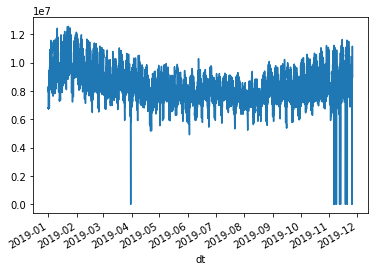

In [6]:
df.W.plot()

In [7]:
df['W'] = df['W'].replace(0, None).interpolate(method='akima')

<AxesSubplot:xlabel='dt'>

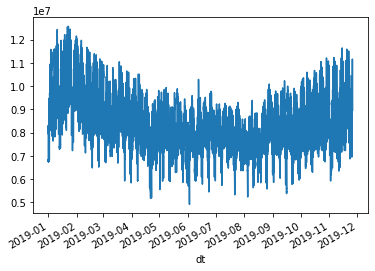

In [8]:
df.W.plot()

In [9]:
df=df.sort_index()

In [10]:
df=df.loc[:pd.to_datetime('2019-11-24 23:45:00')].copy()

In [11]:
x = create_features(df)
y = df['W']

In [12]:
x_train, x_test, y_train, y_test = x.iloc[-2688:-670], x.iloc[-670:], y.iloc[-2688:-670], y.iloc[-670:]

# XGBoost

mean_absolute_percentage_error: 6.320079573797931
r2_score: 0.511465518674511
median_absolute_error: 427700.5
mean_absolute_error: 555227.8850746269
mean_squared_error: 516901085065.77985
mean_squared_log_error: 0.005967037761371729


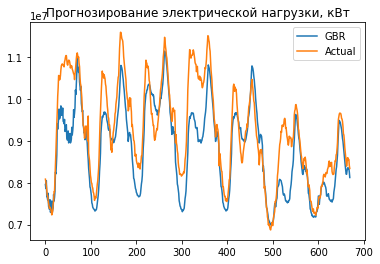

In [13]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
import warnings 
from sklearn import ensemble
from xgboost import XGBRegressor


# model = ensemble.GradientBoostingRegressor(loss='lad', learning_rate=0.12, n_estimators=100, 
#                         subsample=1, min_samples_split=3, min_samples_leaf=2, 
#                         min_weight_fraction_leaf=0.0, max_depth=3, init=None, random_state=None,
#                         max_features=None, alpha=0.9, verbose=0, max_leaf_nodes=None, warm_start=False)
model = XGBRegressor()
model.fit(x_train,y_train)
DATA = model.predict(x_test)
print('mean_absolute_percentage_error:', mean_absolute_percentage_error(DATA, y_test))
print('r2_score:', r2_score(DATA, y_test))
print('median_absolute_error:', median_absolute_error(DATA, y_test))
print('mean_absolute_error:', mean_absolute_error(DATA, y_test))
print('mean_squared_error:',  mean_squared_error(DATA, y_test))
print('mean_squared_log_error:', mean_squared_log_error(DATA, y_test))
DATA = pd.DataFrame(DATA)
DATA.columns = ['GBR']
DATA['Actual'] = y_test.values
error = mean_absolute_percentage_error(DATA, y_test)
DATA.plot()
plt.title('Прогнозирование электрической нагрузки, кВт')
plt.show()

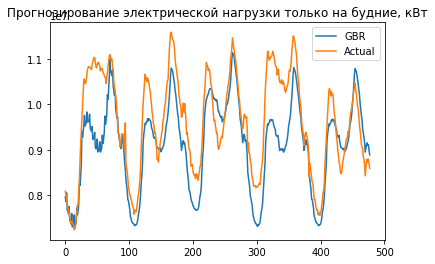

In [14]:
DATA['weekday'] = x_test['weekday'].values
DATA[DATA['weekday']==0].drop('weekday', axis=1).reset_index(drop=True).plot()
plt.title('Прогнозирование электрической нагрузки только на будние, кВт')
plt.show()

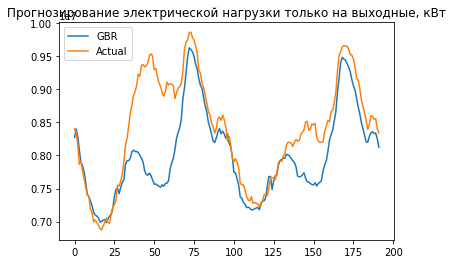

In [15]:
DATA[DATA['weekday']==1].drop('weekday', axis=1).reset_index(drop=True).plot()
plt.title('Прогнозирование электрической нагрузки только на выходные, кВт')
plt.show()

<AxesSubplot:xlabel='15 хв інтервал'>

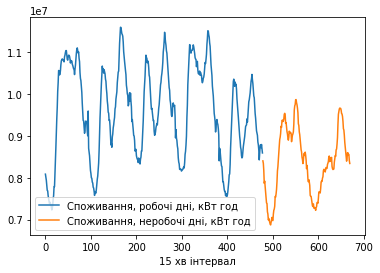

In [16]:
DATA['W_w']=None
DATA['W']=None
DATA.loc[DATA.weekday==0, 'W_w']=DATA.loc[DATA.weekday==0, 'Actual']
DATA.loc[DATA.weekday==1, 'W']=DATA.loc[DATA.weekday==1, 'Actual']
DATA=DATA[['W_w', 'W']].rename(columns={'W_w':'Споживання, робочі дні, кВт год','W':'Споживання, неробочі дні, кВт год' })
DATA=DATA.reset_index(drop=True)
DATA=DATA.reset_index()
DATA=DATA.rename(columns={"index":"15 хв інтервал"})
DATA.plot(x="15 хв інтервал")

In [17]:
DATA =pd.DataFrame(y_test).rename(columns={'W':'Actual'})
DATA['XGB'] = model.predict(x_test)

# Holte Winters

/home/adanik/adanik/myvenv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/home/adanik/adanik/myvenv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


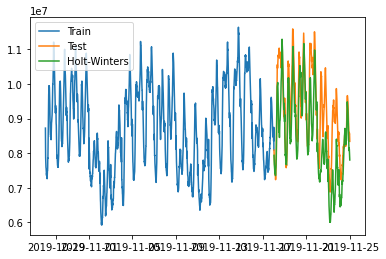

In [18]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(y_train.reset_index(drop=True), seasonal='mul', seasonal_periods=24*7*4).fit()
pred = model.predict(start=y_train.shape[0], end=y_train.shape[0] + y_test.shape[0]-1)
pred.index=y_test.index
plt.plot(y_train.index, y_train, label='Train')
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, pred, label='Holt-Winters')
plt.legend(loc='best')

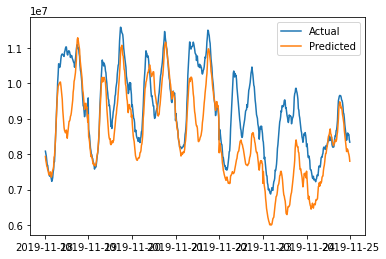

In [19]:
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, pred, label='Predicted')
plt.legend(loc='best')

In [20]:
model.summary()

Dep. Variable:,W,No. Observations:,2018
Model:,ExponentialSmoothing,SSE,31112635476933.027
Optimized:,True,AIC,48687.804
Trend:,None,BIC,52468.851
Seasonal:,Multiplicative,AICC,49370.357
Seasonal Periods:,672,Date:,"Thu, 12 Nov 2020"
Box-Cox:,False,Time:,02:11:03
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.8300000,alpha,True
smoothing_seasonal,0.1700000,gamma,True


In [21]:
DATA['HW'] = pred.values
DATA

,Actual,XGB,HW
dt,,,
2019-11-18 00:30:00,8085068.0,7956773.5,7.935855e+06
2019-11-18 00:45:00,8011388.0,7861621.0,7.816248e+06
2019-11-18 01:00:00,7938153.0,8049301.0,7.748077e+06
2019-11-18 01:15:00,7825839.0,7663862.5,7.662108e+06
2019-11-18 01:30:00,7696941.0,7651573.5,7.634253e+06
...,...,...,...
2019-11-24 22:45:00,8590685.0,8359398.0,8.110388e+06
2019-11-24 23:00:00,8549714.0,8330773.0,8.035301e+06
2019-11-24 23:15:00,8555707.0,8338852.0,7.995516e+06


# SVR

In [22]:
from sklearn.pipeline import make_pipeline
sc_y=StandardScaler()
y_train_tr = sc_y.fit_transform(pd.DataFrame(y_train)).ravel()
regr = SVR(C=10, epsilon=0.2)
regr.fit(x_train, y_train_tr)

SVR(C=10, epsilon=0.2)

In [24]:
pred = regr.predict(x_test)
pred = sc_y.inverse_transform(pred)

In [25]:
DATA['SVR'] = pred

In [26]:
DATA

,Actual,XGB,HW,SVR
dt,,,,
2019-11-18 00:30:00,8085068.0,7956773.5,7.935855e+06,7.975433e+06
2019-11-18 00:45:00,8011388.0,7861621.0,7.816248e+06,7.881340e+06
2019-11-18 01:00:00,7938153.0,8049301.0,7.748077e+06,7.576396e+06
2019-11-18 01:15:00,7825839.0,7663862.5,7.662108e+06,7.552538e+06
2019-11-18 01:30:00,7696941.0,7651573.5,7.634253e+06,7.486905e+06
...,...,...,...,...
2019-11-24 22:45:00,8590685.0,8359398.0,8.110388e+06,8.525483e+06
2019-11-24 23:00:00,8549714.0,8330773.0,8.035301e+06,8.146884e+06
2019-11-24 23:15:00,8555707.0,8338852.0,7.995516e+06,8.155799e+06


# LSTM

In [27]:
import keras

In [28]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [29]:
train = pd.DataFrame(y.iloc[-2698:-680], columns=['W'])
test = pd.DataFrame(y.iloc[-680:], columns=['W'])

In [30]:
time_steps = 10

# reshape to [samples, time_steps, n_features]
sc_y = StandardScaler()
train['W'] = sc_y.fit_transform(train).ravel()
test['W'] = sc_y.transform(test).ravel()
X_train, y_train = create_dataset(train, train.W, time_steps)
X_test, y_test = create_dataset(test, test.W, time_steps)

print(X_train.shape, y_train.shape)

(2008, 10, 1) (2008,)


In [31]:
model = keras.Sequential()
model.add(keras.layers.LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(0.001))

In [32]:
history = model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=16, 
    validation_split=0.1, 
    verbose=1, 
    shuffle=False
)

Epoch 1/30
113/113 [==============================] - 1s 6ms/step - loss: 0.1489 - val_loss: 0.0326
Epoch 2/30
113/113 [==============================] - 0s 4ms/step - loss: 0.0438 - val_loss: 0.0232
Epoch 3/30
113/113 [==============================] - 0s 4ms/step - loss: 0.0317 - val_loss: 0.0184
Epoch 4/30
113/113 [==============================] - 0s 4ms/step - loss: 0.0258 - val_loss: 0.0151
Epoch 5/30
113/113 [==============================] - 0s 4ms/step - loss: 0.0231 - val_loss: 0.0122
Epoch 6/30
113/113 [==============================] - 0s 4ms/step - loss: 0.0210 - val_loss: 0.0113
Epoch 7/30
113/113 [==============================] - 0s 4ms/step - loss: 0.0188 - val_loss: 0.0108
Epoch 8/30
113/113 [==============================] - 0s 4ms/step - loss: 0.0174 - val_loss: 0.0104
Epoch 9/30
113/113 [==============================] - 0s 4ms/step - loss: 0.0163 - val_loss: 0.0100
Epoch 10/30
113/113 [==============================] - 0s 4ms/step - loss: 0.0154 - val_loss: 0.0097

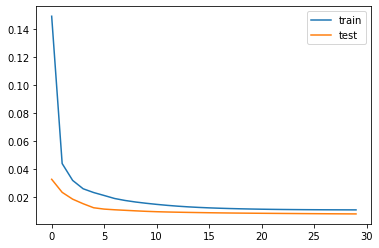

In [33]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [34]:
y_pred = model.predict(X_test)

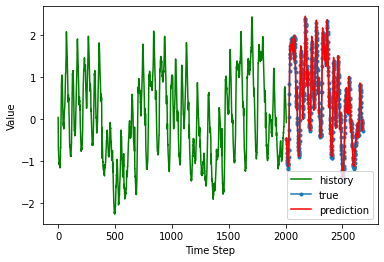

In [35]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)),
         y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)),
         y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show()

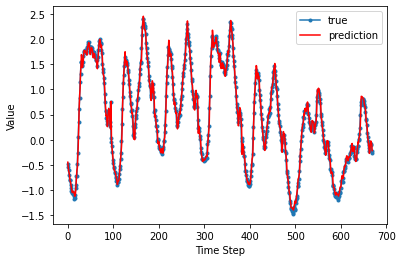

In [36]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show()

In [37]:
y_pred.shape

(670, 1)

In [38]:
DATA['LSTM'] = sc_y.inverse_transform(y_pred)

In [39]:
DATA

,Actual,XGB,HW,SVR,LSTM
dt,,,,,
2019-11-18 00:30:00,8085068.0,7956773.5,7.935855e+06,7.975433e+06,8125646.0
2019-11-18 00:45:00,8011388.0,7861621.0,7.816248e+06,7.881340e+06,8005376.0
2019-11-18 01:00:00,7938153.0,8049301.0,7.748077e+06,7.576396e+06,7915694.5
2019-11-18 01:15:00,7825839.0,7663862.5,7.662108e+06,7.552538e+06,7863105.5
2019-11-18 01:30:00,7696941.0,7651573.5,7.634253e+06,7.486905e+06,7782861.0
...,...,...,...,...,...
2019-11-24 22:45:00,8590685.0,8359398.0,8.110388e+06,8.525483e+06,8581983.0
2019-11-24 23:00:00,8549714.0,8330773.0,8.035301e+06,8.146884e+06,8640037.0
2019-11-24 23:15:00,8555707.0,8338852.0,7.995516e+06,8.155799e+06,8594238.0


In [40]:
DATA.columns

Index(['Actual', 'XGB', 'HW', 'SVR', 'LSTM'], dtype='object')

In [41]:
DATA['hour']=x_test.hour

In [42]:
for col in ['XGB', 'HW', 'SVR', 'LSTM']:
    DATA[col]=DATA.apply(lambda x: mean_absolute_percentage_error(x[col], x['Actual']), axis=1)
DATA=DATA.drop('Actual', axis=1)

In [43]:
def plot_bars(time_range):
    
    df1 =DATA[DATA.hour.isin(list(range(time_range[0], time_range[1])))].drop('hour', axis=1)
    df1 = pd.DataFrame(df1.mean()).reset_index()
    df1.columns=[f'Часовий проміжок {time_range}', "Середня абсолютна похибка, %"]
#     if time_range[0]==18:
#         df1.loc[df1[f'Часовий проміжок {time_range}']=='XGB', "Середня абсолютна похибка, %"]+=1
    ax = df1.plot.bar(x=f'Часовий проміжок {time_range}', y="Середня абсолютна похибка, %", rot=0,  color=['orange', 'grey', 'blue', 'green'])

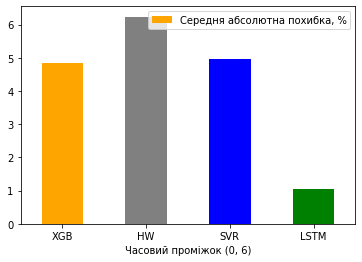

In [44]:
plot_bars((0,6))

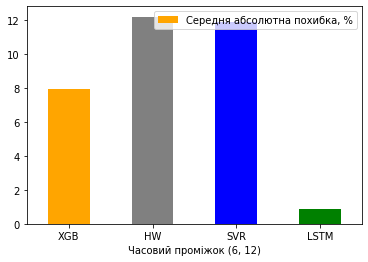

In [45]:
plot_bars((6,12))

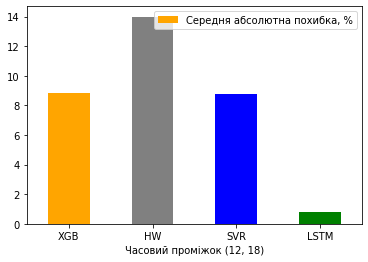

In [46]:
plot_bars((12,18))

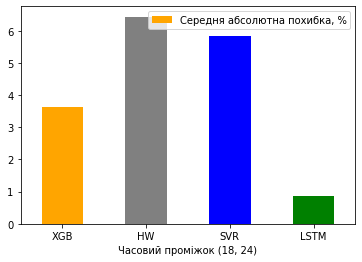

In [47]:
plot_bars((18,24))

In [48]:
DATA

,XGB,HW,SVR,LSTM,hour
dt,,,,,
2019-11-18 00:30:00,1.612394,1.880241,1.374653,0.499382,0
2019-11-18 00:45:00,1.905040,2.496591,1.650079,0.075100,0
2019-11-18 01:00:00,1.380840,2.453197,4.774790,0.283721,1
2019-11-18 01:15:00,2.113510,2.136897,3.618659,0.473941,1
2019-11-18 01:30:00,0.592917,0.821141,2.805380,1.103964,1
...,...,...,...,...,...
2019-11-24 22:45:00,2.766790,5.922003,0.764794,0.101398,22
2019-11-24 23:00:00,2.628099,6.401907,4.944589,1.045401,23
2019-11-24 23:15:00,2.600538,7.006311,4.903364,0.448335,23
